# PTAL Analysis of Jaipur Metro

This notebook downloads data geometry data from open street maps and calculates the public transport accessibility level (PTAL) for the metro rail services provided by Jaipur Metro Rail Corporation. The metro route(s) data used in this study is taken from the [JMRC website](https://www.bing.com/ck/a?!&&p=8dc392b6063139b7JmltdHM9MTcwODMwMDgwMCZpZ3VpZD0zNGY0ZGIzNi0zYjFmLTYyNTgtMGIxMi1jZjEwM2E1ZjYzYjYmaW5zaWQ9NTUyOA&ptn=3&ver=2&hsh=3&fclid=34f4db36-3b1f-6258-0b12-cf103a5f63b6&u=a1aHR0cHM6Ly93d3cuYmluZy5jb20vYWxpbmsvbGluaz91cmw9aHR0cHMlM2ElMmYlMmZ3d3cudHJhbnNwb3J0LnJhamFzdGhhbi5nb3YuaW4lMmZqbXJjJnNvdXJjZT1zZXJwLWxvY2FsJmg9OHhwc3BpUDdJNWYlMmJleVFGT2clMmZidHYlMmYlMmZiQ1F0SW1sa0dkTHREdWVFaXJBJTNkJnA9bHdfZ2J0JmlnPUNCQzJFNEYyMDI4NzQyNDQ4NTU3QUEwNTI2MzUzQzVFJnlwaWQ9WU40MDcweDE2ODMzMTUzMzYxOTUwMjY1Mjk&ntb=1). This notebook follows the method laid out by Adhvaryu et al. (2019). [Mapping public transport accessibility levels (PTAL) in India and its applications: A case study of Surat](https://www.sciencedirect.com/science/article/pii/S2213624X17302134). Lastly, a PTAL map is plotted depicting the public transport accessibility level (PTAL) for Jaipur metro from the centroid of 1 square kilometer grid across Jaipur.

*Abbreviations:*
`SAP`: Service Access Point (Metro stops in this case)
`POI`: Point of Interest (Centroid of 1 square kilometer grid)

In [1]:
import numpy as np
import pandas as pd
from shapely import wkt
from scripts_py.scripts import *
from credentials.credentials import *
import plotly.offline



## 1. Data Collection

### 1.1 Download city boundary/shape file

In [4]:
# get shapefile of the city (Jaipur)
city_shape, city_geometry = get_city_boundary(place_name="Jaipur, India", plot=False)

### 1.2 Download metro stops locations

In [8]:
# specify tags for collecting POIs
tags = {'station': 'subway'}
# collect all the metro stops within the specified bbox
metro = ox.geometries_from_polygon(city_shape, tags=tags)

In [11]:
metro_stops = metro.reset_index()[2:]
metro_stops['lat'] = metro_stops.geometry.centroid.y
metro_stops['lon'] = metro_stops.geometry.centroid.x

In [ ]:
# format dataframe
metro_stops['routes'] = 'pink line'
metro_stops = metro_stops[['name', 'lat', 'lon', 'routes', 'geometry']]

### 1.3 Download road network

In [13]:
# get road network for 'walking'

streets_graph = ox.graph_from_polygon(city_shape,
                                      network_type='walk')
streets_graph = ox.projection.project_graph(streets_graph)

## 2. Create grids across the district boundaries

In [14]:
# projecting shapefile to local CRS system for accurate distance measurement
city_geometry = set_local_crs(gdf=city_geometry)

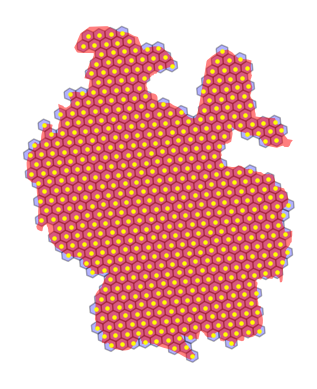

In [15]:
grid = create_hex_grid(geometry=city_geometry, plot=True)

In [16]:
# Extract latitude and longitude from the Point geometry if not already done
grid['latitude'] = grid.POI.y
grid['longitude'] = grid.POI.x

# Apply the get_address_from_coordinates function to each row
grid['address'] = ''
# grid['address'] = grid.apply(lambda row: get_address_from_coordinates(row['latitude'], row['longitude']), axis=1)

grid.drop(['latitude', 'longitude'], axis=1, inplace=True)

## 3. Link SAP and POI to street network

In [17]:
# create a street graph
nodes = ox.graph_to_gdfs(streets_graph, nodes=True, edges=False)
edges = ox.graph_to_gdfs(streets_graph, edges=True, nodes=False)
# uncomment following to plot the street network graph
# ox.plot_graph(streets_graph)

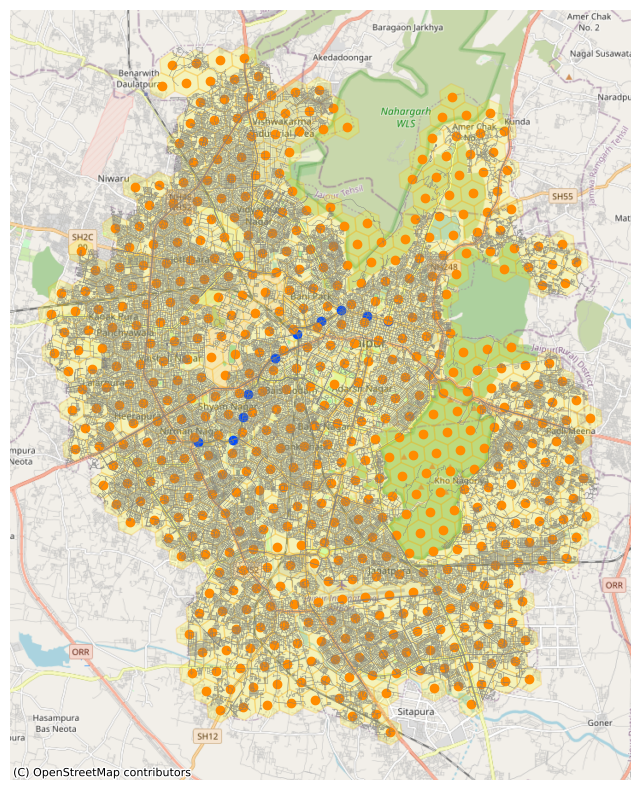

In [18]:
# Reprojecting GeoDataFrames to Web Mercator (EPSG:3857) for consistency with the basemap
road_network = edges.to_crs(epsg=3857)
sap = metro_stops.to_crs(epsg=3857)
grid_1 = grid.to_crs(epsg=3857)
poi = gpd.GeoSeries(grid['POI'], crs='EPSG:4326').to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot road network first with reduced line width (linewidth or lw)
road_network.plot(ax=ax, color='grey', alpha=0.8, linewidth=0.2)

# Plot grid_1 with a different edge color and transparency over the road network
grid_1.plot(ax=ax, color='yellow', edgecolor='orange', alpha=0.2)

# Plot sap and poi over the road network and grid_1
sap.plot(ax=ax, color='#004CFF')
poi.plot(ax=ax, color='#FF8C00')

# Adding the OpenStreetMap basemap
provider = ctx.providers.OpenStreetMap.Mapnik
ctx.add_basemap(ax, source=provider)

# Removing axis for a cleaner look
ax.set_axis_off()

plt.show()


In [19]:
# set service points (bus stops) as destination
destinations = metro_stops.to_crs(nodes.crs)
# link the nearest node in street network
destinations = get_nearest_nodes(destinations, streets_graph)

100%|██████████| 12/12 [00:08<00:00,  1.33it/s]


In [20]:
# set grid centroids as origin points (assuming to be starting point of the trips)
origins = grid.to_crs(nodes.crs)
origins.dropna(inplace=True)
# link the nearest node in street network
origins = get_nearest_nodes(origins, streets_graph)

100%|██████████| 534/534 [06:36<00:00,  1.35it/s]


In [21]:
# impute missing edge speeds and calculate edge travel times with the speed module
streets_graph = ox.speed.add_edge_speeds(streets_graph)
streets_graph = ox.speed.add_edge_travel_times(streets_graph)

In [25]:
destinations['routes'] = 'pink line'

In [26]:
city_grid = nearest_sap(origins, destinations)

100%|██████████| 534/534 [00:02<00:00, 247.19it/s]


## 4. Calculate the route from POI to SAP and walking time (WT)

In [27]:
# calculate the shortest path to walk to the nearest SAP
city_grid = get_walking_route(graph=streets_graph, trips=city_grid)

100%|██████████| 534/534 [00:30<00:00, 17.32it/s]


In [28]:
city_grid = city_grid.replace(r'^\s*$', np.nan, regex=True)

In [32]:
# walking speed is assumed to be 3.6 kmph
walking_speed = 3.6
# convert walking speed to m/min
walking_speed = walking_speed * 16.6666667


city_grid['WT'] = city_grid['walking_distance'] / walking_speed

In [33]:
# fill the nan with mode
city_grid.loc[city_grid['WT'].isna(), 'WT'] = city_grid['WT'].mode()[0]

## 5. Calculate waiting time at each SAP

In [34]:
# Metro runs every 12 minutes during operation time
city_grid['frequency'] = 12

In [35]:
# reliability factor k
k_metro = 2

In [37]:
# Calculate Average Waiting Time (AWT) for each SAP
city_grid['AWT'] = city_grid.frequency / 2 + k_metro
city_grid['TAT'] = city_grid['WT'] + city_grid['AWT']
city_grid['EDF'] = 30 / city_grid['TAT']

## 6. Calculate Accessibility index for each POI

In [39]:
# High frequency routes have weighing factor of 1; others have 0.5
city_grid['weighing_factor'] = 1

In [40]:
city_grid['accessibility_index'] = city_grid['weighing_factor'] * city_grid['EDF']

In [42]:
mapbox_token = get_mapbox_token()

In [44]:
gdf = reset_crs(city_grid)

# Create the choropleth map using Plotly Graph Objects
fig = go.Figure(go.Choroplethmapbox(geojson=gdf.geometry.__geo_interface__,
                                    locations=gdf.index,
                                    z=gdf['accessibility_index'],
                                    hovertext=gdf['sap_name'],
                                    colorscale='sunsetdark',
                                    zmin=0,
                                    zmax=gdf['EDF'].quantile(0.9),
                                    marker_opacity=0.6,
                                    )
                )

# Set the Mapbox token and layout
mapbox_token = get_mapbox_token()
fig.update_layout(
    title_text='Choropleth Map: Accessibility Index',
    mapbox_style='mapbox://styles/mapbox/streets-v12',
    mapbox_accesstoken=mapbox_token,
    mapbox_zoom=10,  # Adjust the initial zoom level
    mapbox_center={'lat': 26.933985, 'lon': 75.873857},
    coloraxis_colorbar=dict(
        title='Accessibility Index',
        thickness=20,
        lenmode='fraction',
        len=0.5,
        yanchor='top',
        y=0.98,
        tickfont=dict(size=10),
        ticksuffix=' units',
        dtick=10)
)

fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.write_html('../figures/AI-bus.html',
               full_html=False,
               include_plotlyjs='cdn')
fig.show()


In [51]:
metro_ptal = reset_crs(city_grid)

In [58]:
metro_ptal.rename(columns={'accessibility_index':'metro_ptal'}, inplace=True)

In [55]:
# Read the CSV file into a GeoDataFrame
grid = pd.read_csv("../data/ai/ai_jctsl.csv")
# Read the CRS information from the separate .prj file
prj_path = "../data/ai/ai_jctsl.csv".replace('.csv', '.prj')
with open(prj_path, 'r') as prj_file:
    crs = prj_file.read()

grid['geometry'] = grid['geometry'].apply(wkt.loads)
# Set the CRS of the GeoDataFrame
grid = gpd.GeoDataFrame(data=grid, geometry=grid['geometry'], crs=crs)

In [59]:
grid.rename(columns={'accessibility_index':'bus_ptal'}, inplace=True)

In [65]:
grid

geometry  \
0    POLYGON ((75.84022 26.79287, 75.84069 26.78821...   
1    POLYGON ((75.77923 26.96383, 75.77971 26.95917...   
2    POLYGON ((75.74661 26.90450, 75.74709 26.89983...   
3    POLYGON ((75.80028 26.85279, 75.80076 26.84814...   
4    POLYGON ((75.70417 26.89369, 75.70466 26.88903...   
..                                                 ...   
529  POLYGON ((75.79599 26.89473, 75.79647 26.89007...   
530  POLYGON ((75.69313 26.90683, 75.69362 26.90216...   
531  POLYGON ((75.82780 26.81996, 75.82827 26.81531...   
532  POLYGON ((75.79742 26.88075, 75.79790 26.87609...   
533  POLYGON ((75.74397 26.88310, 75.74446 26.87844...   

                                              POI  address         node  \
0      POINT (75.8452421534189 26.79096017339389)      NaN   9603133742   
1     POINT (75.78426829958505 26.96192421181197)      NaN   3901400244   
2    POINT (75.75164172072695 26.902588215945663)      NaN   3659487058   
3     POINT (75.8053124432975 26.850885899139673)      NaN   3787808869   
4    POINT (75.70921081070567 26.891785343463475)      NaN   8629131330   
..                                            ...      ...          ...   
529   POINT (75.80102494302415 26.89282340770849)      NaN   7098288462   
530   POINT (75.6981701411167 26.904920496722635)      NaN   3933330079   
531  POINT (75.83282584830035 26.818055914927978)      NaN  11602138589   
532  POINT (75.80245471024205 26.878841836499383)      NaN   8637073397   
533   POINT (75.74900844982933 26.88119139968982)      NaN   3787305627   

                                      nearest_sap   destination  \
0     POINT (583507.229814946 2964580.8345124293)  4.805542e+09   
1    POINT (577970.8764481898 2982502.0051072054)  2.414234e+09   
2    POINT (574853.6189018721 2975286.8758732784)  5.481780e+09   
3    POINT (580425.2320770696 2969709.1958344243)  3.785003e+09   
4     POINT (571126.7639187786 2973130.450876301)  8.120331e+09   
..                                            ...           ...   
529  POINT (580048.7360711186 2974682.0611738022)  8.044665e+09   
530   POINT (569643.4933595578 2978255.384474142)  3.935403e+09   
531    POINT (583137.95029687 2965321.5405066554)  3.778163e+09   
532   POINT (579360.4002339747 2973319.681503308)  3.783170e+09   
533  POINT (574607.7079824471 2973312.2111683004)  3.783104e+09   

                    sap_name                                        routes  \
0                DWARKA PURI                                             3   
1           VIDHYADHAR THANA                                            9A   
2    PURANI CHUNGI AGRA ROAD                                         14,32   
3     SECTOR 10 PRATAP NAGAR                                             3   
4          KAMLA NEHRU NAGAR                                         26,32   
..                       ...                                           ...   
529    LAL KOTHI SABJI MANDI  AC1,AC2,3,3A,11,6A,AC7,9A,16,23,27A,28,32,34   
530          JHOTWARA CIRCLE                                           AC8   
531                      NRI                                             3   
532              TONK PHATAK     AC2,3,3A,6A,7,9A,11,AC1,28,16,27,32,23,34   
533        MANSAROWER METRO                                           7,32   

     walking_distance         WT  service_frequency   AWT        TAT  \
0              1333.0  22.216667               20.0  14.0  36.216667   
1               170.0   2.833333                8.0   8.0  10.833333   
2               875.0  14.583333               35.0  21.5  36.083333   
3               969.0  16.150000               11.0   9.5  25.650000   
4              1930.0  32.166667              120.0  64.0  96.166667   
..                ...        ...                ...   ...        ...   
529             707.0  11.783333               16.0  12.0  23.783333   
530            3215.0  53.583333               15.0  11.5  65.083333   
531            1401.0  23.350000               14.0  11.0 

In [69]:
metro_ptal = metro_ptal[['metro_ptal', 'geometry']]

In [74]:
grid = gpd.sjoin(grid, metro_ptal,predicate="covers")

In [76]:
grid['accessibility_index'] = grid['bus_ptal'] + grid['metro_ptal']

In [77]:
# store data to a csv file
grid.to_csv("../data/ai/ai.csv", index=False, encoding='utf-8', header=True)

# Write the CRS information to a separate file
with open("../data/ai/ai.csv".replace('.csv', '.prj'), 'w') as prj_file:
    prj_file.write(grid.crs.to_wkt())